In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [90]:
#convert MNIST image files into tensor of 4 dim (#images,height,width,channel)
transform = transforms.ToTensor()
training_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
testing_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
training_data, testing_data 

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [98]:
# Data Loader
train_loader = DataLoader(training_data, batch_size=10, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=10, shuffle=False)

In [99]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(5*5*16, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 10)
        
    def forward(self, X):
        # conv1
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # conv2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        # flatten
        X = X.view(-1, 5*5*16)
        # fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

torch.manual_seed(69)
model = ConvNetwork()
model.eval()

ConvNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [100]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [101]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#epoch loops
for i in range(epochs):
    train_ok_count = 0
    test_ok_count = 0
    
    print(f'{"=" * 12} Epoch {i+1} {"=" * 12}')
    #Train
    for j, (X_train, Y_train) in enumerate(train_loader):
        j+=1
        Y_predicted = model(X_train)
        predicted = torch.max(Y_predicted.data, 1)[1]
        loss = criterion(Y_predicted, Y_train)
        train_ok_count += (predicted == Y_train).sum()
        
        #update params
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #print out result
        if j%600 == 0:
            print(f'Batch: {j} \t Loss: {loss.item():>5f}')
            
    train_losses.append(loss)
    train_correct.append(train_ok_count)
    
    #test
    with torch.no_grad():
        for j, (X_test, Y_test) in enumerate(train_loader):
            Y_predicted = model(X_test)
            predicted = torch.max(Y_predicted.data, 1)[1]
            test_ok_count += (predicted == Y_test).sum()
            loss = criterion(Y_predicted, Y_test)
    test_losses.append(loss)
    test_correct.append(test_ok_count)
    
current_time = time.time()

total_time = current_time - start_time
print(f'training took: {total_time/60} minutes')

============ Epoch 1 ============
Batch: 600 	 Loss: 0.508807
Batch: 1200 	 Loss: 0.052823
Batch: 1800 	 Loss: 0.271041
Batch: 2400 	 Loss: 0.037797
Batch: 3000 	 Loss: 0.066453
Batch: 3600 	 Loss: 0.456081
Batch: 4200 	 Loss: 0.094370
Batch: 4800 	 Loss: 0.016962
Batch: 5400 	 Loss: 0.572903
Batch: 6000 	 Loss: 0.253359
============ Epoch 2 ============
Batch: 600 	 Loss: 0.072003
Batch: 1200 	 Loss: 0.006032
Batch: 1800 	 Loss: 0.035783
Batch: 2400 	 Loss: 0.196136
Batch: 3000 	 Loss: 0.016228
Batch: 3600 	 Loss: 0.303640
Batch: 4200 	 Loss: 0.793881
Batch: 4800 	 Loss: 0.083588
Batch: 5400 	 Loss: 0.127761
Batch: 6000 	 Loss: 0.247708
============ Epoch 3 ============
Batch: 600 	 Loss: 0.010706
Batch: 1200 	 Loss: 0.193535
Batch: 1800 	 Loss: 0.004234
Batch: 2400 	 Loss: 0.013917
Batch: 3000 	 Loss: 0.255019
Batch: 3600 	 Loss: 0.160301
Batch: 4200 	 Loss: 1.001816
Batch: 4800 	 Loss: 0.020055
Batch: 5400 	 Loss: 0.155570
Batch: 6000 	 Loss: 0.918099
============ Epoch 4 ==========

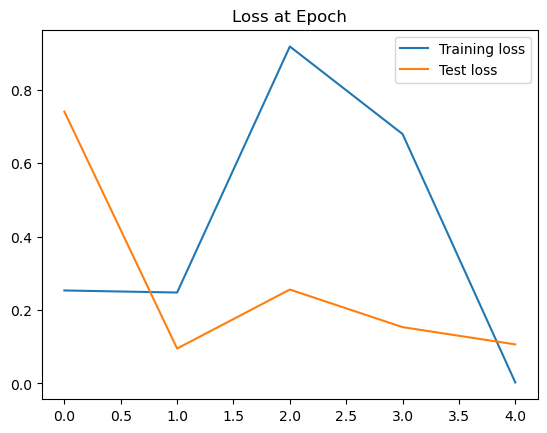

In [102]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.title('Loss at Epoch')
plt.legend()

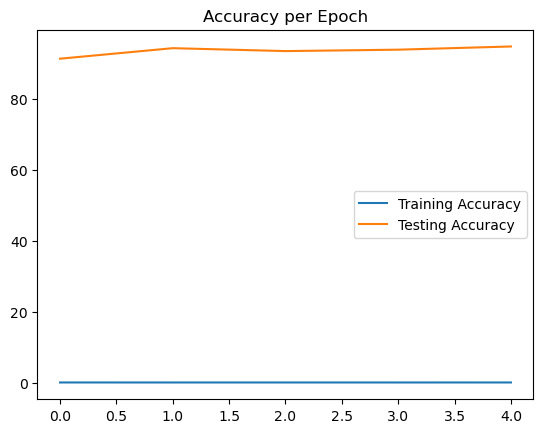

In [103]:
#Accuracy graph
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/600 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

In [104]:
test_load_everything = DataLoader(testing_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct =0
    for X_test, Y_test in test_load_everything:
        Y_predicted = model(X_test)
        predicted = torch.max(Y_predicted, 1)[1]
        correct += (predicted == Y_test).sum()

print(f'Correct prdictions: {correct.item() /len(X_test) * 100}%')

Correct prdictions: 94.89999999999999%
